In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import os, sys, re, pickle, glob
import urllib.request
import zipfile
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models, optimizers
import matplotlib.pyplot as plt

import numpy as np

%matplotlib inline

# **Manual Load Data**

In [ ]:
import numpy as np
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import smart_resize
from tqdm import tqdm

classes_index = {'ANGER':0, 'FEAR':1, 'SURPRISE':2,'SADNESS':3, 'HAPPINESS':4, 'DISGUST':5}

def prepare_image_data(data_dir, target_size, name_extend=''):
  x = []
  y = []
  for key in tqdm(classes_index.keys()):
      for _file in os.listdir(os.path.join(data_dir,key)):
          filename = os.path.join(data_dir, key, _file)
          image = load_img(filename)
          frame_bgr = img_to_array(image)
          ds = smart_resize(frame_bgr, target_size)
          x.append(ds)
          y.append(classes_index[key])

  x = np.array(x)
  x = x / 255.0
  print(x.shape)
  y = np.array(y)
  print(y.shape)

  with open('x_{}.pkl'.format(name_extend),'wb') as f:
      pickle.dump(x, f)

  with open('y_{}.pkl'.format(name_extend),'wb') as f:
      pickle.dump(y, f)

  return x,y

load pickle file

In [ ]:
import pickle

def load_pickle(pickle_name):
  dir = '/content/drive/MyDrive/data/pickle_images/{}'
  with open(dir.format(pickle_name),'rb') as f:
        return pickle.load(f)

load aligned train data

In [ ]:

data_dir = '/content/drive/MyDrive/data/aligned'
target_image_size = (96, 96)

x_align, y_align = prepare_image_data(data_dir, target_image_size, name_extend='align')

100%|██████████| 6/6 [10:00<00:00, 100.10s/it]


(32334, 96, 96, 3)
(32334,)


load validation/test data

In [ ]:
data_dir = '/content/drive/MyDrive/data/test'
target_image_size = (96, 96)

x_test, y_test = prepare_image_data(data_dir, target_image_size, name_extend='test')

100%|██████████| 6/6 [02:56<00:00, 29.44s/it]


(10861, 96, 96, 3)
(10861,)


In [ ]:
x_align = load_pickle('x_align.pkl')
y_align = load_pickle('y_align.pkl')

In [ ]:
x = load_pickle('x_test.pkl')
y = load_pickle('y_test.pkl')

In [ ]:
x_prod = load_pickle('x_prod.pkl')
y_prod = load_pickle('y_prod.pkl')

In [ ]:
print(x_test.shape, 'x_test')
print(y_test.shape, 'y_test')

In [ ]:
from sklearn.model_selection import train_test_split
x_val, x_test, y_val, y_test = train_test_split(x, y, test_size = 0.5, random_state=42)

In [ ]:
print(x_test.shape, 'x_val')
print(x_val.shape, 'x_test')

(5431, 32, 32, 3) x_val
(5430, 32, 32, 3) x_test


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

# **VGG model**

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout

IMG_SIZE=32
# load model without classifier layers
# we are loading the pre-trained model weights from ImageNet which is a very large dataset annotated in terms of 1000 object categories
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
#x = img_augmentation(inputs)
model = VGG16(include_top=False, weights="imagenet", input_shape=(32, 32, 3))
    
### If we want to freeze these pretrained weights:

for layer in model.layers:
  layer.trainable = False     # mark loaded layers as not trainable

# add new classifier layers
flat1 = layers.Flatten()(model.layers[-1].output)
fc1 = layers.Dense(8192, activation='relu')(flat1)
dp1 = layers.Dropout(0.25)(fc1)
fc2 = layers.Dense(8192, activation='relu')(dp1)
dp2 = layers.Dropout(0.25)(fc2)
#fc3 = layers.Dense(4096, activation='relu')(fc2)
output = layers.Dense(6, activation='softmax')(dp2)


# define new model
model = Model(inputs=model.inputs, outputs=output)

model.compile(optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"


checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

Epoch 1/30
126/127 [============================>.] - ETA: 0s - loss: 0.7409 - accuracy: 0.7438
Epoch 1: val_accuracy improved from -inf to 0.84917, saving model to weights-improvement-01-0.85.hdf5
127/127 [==============================] - 14s 106ms/step - loss: 0.7403 - accuracy: 0.7441 - val_loss: 0.4646 - val_accuracy: 0.8492
Epoch 2/30
126/127 [============================>.] - ETA: 0s - loss: 0.4061 - accuracy: 0.8682
Epoch 2: val_accuracy improved from 0.84917 to 0.86722, saving model to weights-improvement-02-0.87.hdf5
127/127 [==============================] - 13s 102ms/step - loss: 0.4062 - accuracy: 0.8681 - val_loss: 0.3851 - val_accuracy: 0.8672
Epoch 3/30
126/127 [============================>.] - ETA: 0s - loss: 0.3062 - accuracy: 0.9019
Epoch 3: val_accuracy improved from 0.86722 to 0.90534, saving model to weights-improvement-03-0.91.hdf5
127/127 [==============================] - 13s 105ms/step - loss: 0.3060 - accuracy: 0.9020 - val_loss: 0.2982 - val_accuracy: 0.905

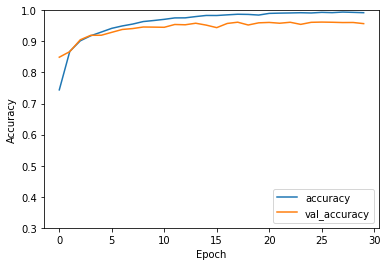

In [ ]:
# Training
num_epochs=30
batch_size=256


history = model.fit(x_align,y_align, epochs=num_epochs, batch_size=batch_size,
                    validation_data=(x_val,y_val), callbacks=[checkpoint], shuffle=True)
"""
history = model.fit_generator(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    max_queue_size=1,
    shuffle=True,
    callbacks=[checkpoint],
    verbose=1
)
"""
# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print(test_acc)

# **data loader**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 32
batch_size = 128

train_dir = '/content/drive/MyDrive/data/aligned'
datagen_train = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(train_dir,
                  target_size = (img_size,img_size),
                  color_mode='rgb',
                  class_mode='sparse',
                  batch_size=batch_size,shuffle= True)

test_dir = '/content/drive/MyDrive/data/test'
datagen_validation = ImageDataGenerator(rescale=1./255)
validation_generator = datagen_validation.flow_from_directory(test_dir,
                        target_size = (img_size,img_size),
                        color_mode='rgb',
                        class_mode='sparse',
                        batch_size=batch_size,shuffle= True)

Found 32334 images belonging to 6 classes.
Found 10861 images belonging to 6 classes.


In [ ]:
prod_dir = '/content/drive/MyDrive/data/FER_prod_data/assignment_2_MLD_qmul'
datagen_prod = ImageDataGenerator(rescale=1./255)
prod_generator = datagen_prod.flow_from_directory(prod_dir,
                        target_size = (img_size,img_size),
                        color_mode='rgb',
                        batch_size=batch_size,
                        class_mode='sparse',shuffle= True)

Found 26143 images belonging to 6 classes.


In [ ]:
for x,y in train_generator:
  print(x.shape, y.shape)
  break

(256, 32, 32, 3) (256,)


In [ ]:
print(y[1:10])

[4. 5. 0. 3. 5. 0. 5. 0. 4.]


In [ ]:
print(type(y[0]))

<class 'numpy.float32'>


# **Task2**

In [ ]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.callbacks import ModelCheckpoint

In [ ]:
n_classes=6
mobilenetv2 = MobileNetV2(input_shape=(32, 32, 3), alpha=1, weights='imagenet', include_top=False, classes=n_classes)

for layer in mobilenetv2.layers:
  layer.trainable = False

x = mobilenetv2.layers[-1].output

final_output = layers.Dense(128)(x) 
final_output = layers.Activation('relu')(final_output) 
final_output = layers.Dense(64)(final_output) 
final_output = layers.Activation('relu')(final_output) 
final_output = layers.Dense(n_classes, activation='softmax')(final_output) 

model = Model(inputs=mobilenetv2.layers[0].output,outputs=final_output)

model.compile(optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
print(model.summary())

Epoch 1/30
127/127 [==============================] - ETA: 0s - loss: 1.7045 - accuracy: 0.2989
Epoch 1: val_accuracy improved from -inf to 0.29962, saving model to weights-improvement-01-0.30.hdf5
127/127 [==============================] - 48s 39ms/step - loss: 1.7045 - accuracy: 0.2989 - val_loss: 1.6082 - val_accuracy: 0.2996
Epoch 2/30
126/127 [============================>.] - ETA: 0s - loss: 1.5441 - accuracy: 0.2836
Epoch 2: val_accuracy did not improve from 0.29962
127/127 [==============================] - 3s 24ms/step - loss: 1.5441 - accuracy: 0.2836 - val_loss: 1.4814 - val_accuracy: 0.2815
Epoch 3/30
125/127 [============================>.] - ETA: 0s - loss: 1.4518 - accuracy: 0.2581
Epoch 3: val_accuracy did not improve from 0.29962
127/127 [==============================] - 3s 24ms/step - loss: 1.4513 - accuracy: 0.2580 - val_loss: 1.4202 - val_accuracy: 0.2420
Epoch 4/30
126/127 [============================>.] - ETA: 0s - loss: 1.4033 - accuracy: 0.2367
Epoch 4: val_ac

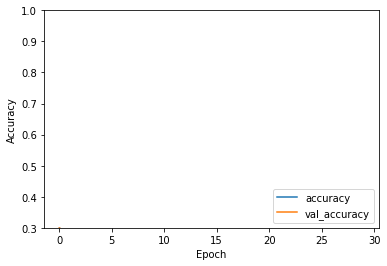

In [ ]:
input_shape=(32,32,3)
num_epochs=30
batch_size=256



filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x_align, y_align, epochs=num_epochs, batch_size=batch_size,
                    validation_data=(x_val,y_val), callbacks=callbacks_list, shuffle=True)
"""
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps= validation_generator.n//validation_generator.batch_size

result = model.fit_generat(train_generator,
                      steps_per_epoch=steps_per_epoch,
                       epochs=epochs,
                       verbose=1,
                       validation_data=validation_generator,
                        validation_steps=validation_steps,
                       callbacks=callbacks_list
                      )
"""

# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,y_test, verbose=2)

print(test_acc)



In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print(test_acc)

170/170 - 2s - loss: 1.3320 - accuracy: 0.4990 - 2s/epoch - 13ms/step
0.4989872872829437


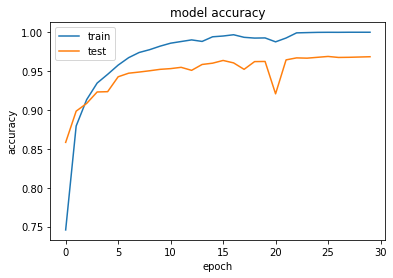

In [ ]:
plt.figure(1)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

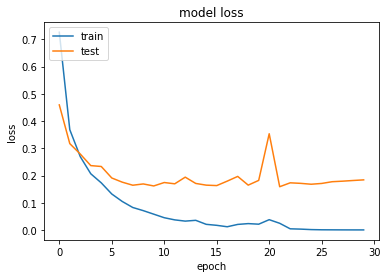

In [ ]:
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print(test_acc)

170/170 - 1s - loss: 1.2068 - accuracy: 0.2352 - 1s/epoch - 8ms/step
0.23522193729877472


# **Result Analyse**

In [ ]:
data_dir = '/content/drive/MyDrive/data/FER_prod_data/assignment_2_MLD_qmul'
target_image_size = (32, 32)

prod_x, prod_y = prepare_image_data(data_dir, target_image_size, name_extend='prod')

In [ ]:
prod_loss, prod_acc = model.evaluate(x_prod,  y_prod, verbose=2)

print(prod_loss, prod_acc)

817/817 - 8s - loss: 5.0337 - accuracy: 0.3759 - 8s/epoch - 10ms/step
5.033720970153809 0.37593236565589905


In [ ]:
predict = model.predict(x_prod, verbose=2).argmax(axis=-1)

817/817 - 8s - 8s/epoch - 10ms/step


In [ ]:
predict=predict.reshape(5431)

In [ ]:
predict.shape

(5431,)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_prod, predict))

              precision    recall  f1-score   support

           0       0.53      0.41      0.46      3427
           1       0.30      0.10      0.14      1362
           2       0.61      0.50      0.55      7246
           3       0.81      0.33      0.46     11955
           4       0.06      0.94      0.12       758
           5       0.06      0.04      0.05      1395

    accuracy                           0.38     26143
   macro avg       0.39      0.39      0.30     26143
weighted avg       0.63      0.38      0.44     26143



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print(f1_score(y_test, predict,average='weighted'))

0.3935195010477083


classes_index = {'ANGER':0, 'FEAR':1, 'SURPRISE':2,'SADNESS':3, 'HAPPINESS':4, 'DISGUST':5}


In [ ]:
from scipy.stats import itemfreq
itemfreq(y_prod)

0 8228

1 2985

2 7418

3 13040

4 9113

5 2651

In [ ]:
from scipy.stats import itemfreq
itemfreq(y_align)

In [ ]:
from scipy.stats import itemfreq
itemfreq(y_test)

In [ ]:
from scipy.stats import itemfreq
itemfreq(y_val)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_prod,predict)
print('Confusion Matrix\n')
print(confusion)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(confusion/np.sum(confusion), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted classes')
ax.set_ylabel('Actual classes ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels( ['A', 'F', 'SUP','SAD', 'H','D'])
ax.yaxis.set_ticklabels(  ['A', 'F', 'SUP','SAD', 'H','D'])

## Display the visualization of the Confusion Matrix.
plt.show()

# **Task2-Alter**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(include_top=False, weights='imagenet')

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
IMG_SIZE=32
NUM_CLASSES=6
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"]
    )
    return model


In [ ]:

model = build_model(num_classes=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x_align, y_align, epochs=num_epochs, batch_size=batch_size,
                    validation_data=(x_val,y_val), callbacks=callbacks_list, shuffle=True)



Epoch 1/30
127/127 [==============================] - ETA: 0s - loss: 1.9291 - accuracy: 0.2472
Epoch 1: val_accuracy improved from -inf to 0.30700, saving model to weights-improvement-01-0.31.hdf5
127/127 [==============================] - 12s 46ms/step - loss: 1.9291 - accuracy: 0.2472 - val_loss: 1.6632 - val_accuracy: 0.3070
Epoch 2/30
127/127 [==============================] - ETA: 0s - loss: 1.7892 - accuracy: 0.2640
Epoch 2: val_accuracy did not improve from 0.30700
127/127 [==============================] - 4s 28ms/step - loss: 1.7892 - accuracy: 0.2640 - val_loss: 1.6689 - val_accuracy: 0.3070
Epoch 3/30
126/127 [============================>.] - ETA: 0s - loss: 1.7573 - accuracy: 0.2687
Epoch 3: val_accuracy did not improve from 0.30700
127/127 [==============================] - 4s 29ms/step - loss: 1.7574 - accuracy: 0.2687 - val_loss: 1.6620 - val_accuracy: 0.3070
Epoch 4/30
125/127 [============================>.] - ETA: 0s - loss: 1.7224 - accuracy: 0.2695
Epoch 4: val_ac

# **REsnet**

In [ ]:
from keras.applications.resnet import ResNet50, ResNet101, ResNet152
from keras.models import Model
# load model without classifier layers
model = ResNet50(include_top=False, weights="imagenet", input_shape=(32, 32, 3)) # or you can load here any other network

### If we want to freeze these pretrained weights:

for layer in model.layers:
	layer.trainable = False     # mark loaded layers as not trainable    

# add new classifier layers
flat1 = layers.Flatten()(model.layers[-1].output)
output = layers.Dense(6, activation='softmax')(flat1)


# define new model
model = Model(inputs=model.inputs, outputs=output)

model.compile(optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

71712768/94765736 [=====================>........] - ETA: 0s

KeyboardInterrupt: ignored

In [ ]:
# Training
history = model.fit(x_align, y_align, epochs=30, batch_size=256,
                    validation_data=(x_val, y_val))

# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print(test_acc)